In [43]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.io import read_image

class MovielensDatasetWithPosters(Dataset):
    def __init__(self, ratings_dir, posters_dir, transform=None):
        self.ratings = pd.read_csv(ratings_dir).values
        self.posters_dir = posters_dir
        self.transform = transform

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        """
        Returns uid, iid, rating and poster
        """
        img_path = os.path.join(self.posters_dir, str(int(self.ratings[idx][1] + 1)) + ".jpg")
        image = read_image(img_path)
        
        if self.transform:
            image = self.transform(image)
        return int(self.ratings[idx][0]), int(self.ratings[idx][1]), float(self.ratings[idx][2]), image

In [57]:
train_dataset = MovielensDatasetWithPosters(ratings_dir="../data/df_train.csv",
                                            posters_dir="../posters",
                                            transform=transforms.Compose([
                                                transforms.Resize([512]),
                                            ]))
validation_dataset = MovielensDatasetWithPosters(ratings_dir="../data/df_val.csv",
                                      posters_dir="../posters",
                                      transform=transforms.Compose([
                                                transforms.Resize(512),
                                            ]))
test_dataset = MovielensDatasetWithPosters(ratings_dir="../data/df_test.csv",
                                posters_dir="../posters",
                                transform=transforms.Compose([
                                                transforms.Resize(512),
                                            ]))

In [58]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=256, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [59]:
for i in train_dataloader:
    break

/Users/migueloteropedrido/Desktop/recommender_system_with_image_information/venv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [60]:
i

[tensor([375]),
 tensor([97]),
 tensor([5.], dtype=torch.float64),
 tensor([[[[255, 254, 254,  ...,   4,   0,   0],
           [253, 252, 252,  ...,   1,   0,   0],
           [251, 250, 250,  ...,   0,   0,   0],
           ...,
           [  0,   0,   0,  ...,   7,  12,  12],
           [  0,   0,   0,  ...,   7,  12,  12],
           [  0,   0,   0,  ...,  12,  12,  12]],
 
          [[255, 254, 254,  ...,   4,   0,   0],
           [255, 254, 254,  ...,   1,   0,   0],
           [254, 253, 254,  ...,   0,   0,   0],
           ...,
           [  0,   0,   0,  ...,   7,  12,  12],
           [  0,   0,   0,  ...,   7,  12,  12],
           [  0,   0,   0,  ...,  12,  12,  12]],
 
          [[255, 254, 254,  ...,   4,   0,   0],
           [254, 253, 253,  ...,   1,   0,   0],
           [253, 252, 253,  ...,   0,   0,   0],
           ...,
           [  0,   0,   0,  ...,   7,  12,  12],
           [  0,   0,   0,  ...,   7,  12,  12],
           [  0,   0,   0,  ...,  12,  12,  12

TypeError: Invalid shape (3, 744, 512) for image data

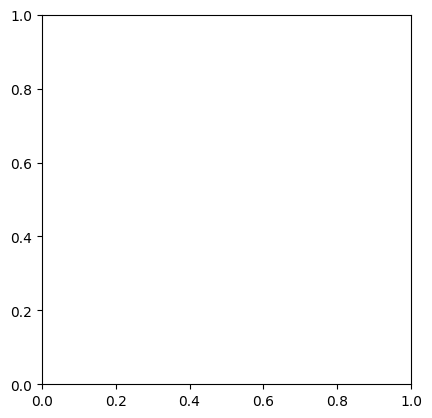

In [61]:
plt.imshow(i[-1][0].squeeze())

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Matrix Factorization with Visual Information

In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=30):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.user_bias = torch.nn.Embedding(n_users, 1)
            
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        self.item_bias = torch.nn.Embedding(n_items, 1) 

        for param in self.parameters():
            torch.nn.init.normal_(param, std=0.01)  
    
    def forward(self, user, item):
        Q = self.user_factors(user)
        bq = self.user_bias(user).flatten()

        I = self.item_factors(item)
        bi = self.item_bias(item).flatten()

        return (Q*I).sum(-1) + bq + bi